In [1]:
import os
import math
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from typing import List

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, IterableDataset
from torchvision import transforms

In [2]:
class DeviceManager():
    """
        A special class designed to store information about available devices, 
        and also has methods that can be overridden to run code on the TPU.
    """
    def __init__(self, rank, world_size, master_process, device):
        self.rank = rank
        self.world_size = world_size
        self.master_process = master_process
        self.device = device
    
    def master_print(self, str):
        if self.master_process:
            print(str)
    
    def rendezvous(self, str):
        pass

    def mark_step(self):
        torch.cuda.synchronize()
    
    def optimizer_step(self, optimizer):
        optimizer.step()
    
    def all_reduce(self, tensor):
        return tensor
    
    def save(self, checkpoint, filename):
        torch.save(checkpoint, filename)
    

class TrainParameters():
    """
    Class for storing various training hyperparameters.
    """
    def __init__(self, T, epochs, show_freq, dataset_path, shard_size, batch_size, target_image_size, save_freq, save_path):
        self.T = T
        self.epochs = epochs
        self.show_freq = show_freq
        self.dataset_path = dataset_path
        self.shard_size = shard_size
        self.batch_size = batch_size
        self.target_image_size = target_image_size
        self.save_freq = save_freq
        self.save_path = save_path

        
class LearningRateScheduler():
    def __init__(self, min_lr, max_lr, warmup_steps_portion):
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.warmup_steps_portion = warmup_steps_portion
    
    def init(self, train_parameters: TrainParameters, dataset_len):
        count_steps_in_epoch = dataset_len // train_parameters.batch_size
        self.max_steps = count_steps_in_epoch * train_parameters.epochs
        self.warmup_steps = int(self.max_steps * self.warmup_steps_portion)
    
    def get_lr(self, total_iteration):
        # 1) linear warmup for warmup_iters steps
        if total_iteration < self.warmup_steps:
            return self.max_lr * (total_iteration + 1) / self.warmup_steps
        # 2) if it > lr_decay_iters, return min_lerning_rate
        if total_iteration > self.max_steps:
            return self.min_lr
        # 3) in between, use cosine decay down to min learning rate
        decay_ratio = (total_iteration - self.warmup_steps) / (self.max_steps - self.warmup_steps)
        assert 0 <= decay_ratio <= 1
        coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff starts at 1 and goes to 0
        return self.min_lr + coeff * (self.max_lr - self.min_lr)


class CatDataset(IterableDataset):
    def __init__(self, path: str, shard_size: int, batch_size: int, target_image_size: tuple, 
                 rank: int, world_size: int, full_in_RAM:bool = False, shuffle: bool = False, allows_ex: List[str] = [".jpg", ".png", ".JPEG"]):
        self.full_in_RAM = full_in_RAM
        self.batch_size = batch_size
        self.rank = rank
        self.world_size = world_size

        self.image_paths = [os.path.join(path, name) for name in os.listdir(path) if os.path.splitext(name)[1] in allows_ex]
        self.image_paths = self.image_paths[:1]

        self.count_images = len(self.image_paths)
        self.shard_size = self.count_images if full_in_RAM else shard_size
        self.count_shards = self.count_images // shard_size

        self.transform = transforms.Compose([
            transforms.Resize(target_image_size),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x * 2 - 1)
        ])
        
        self.reverse_transform = transforms.Compose([
            transforms.Lambda(lambda x: (x + 1) / 2),
            transforms.ToPILImage()
        ])

        if shuffle:
            np.random.shuffle(self.image_paths)
        
        if self.full_in_RAM:
            self.shard = self.get_shard(0)


    def get_shard(self, shard_n) -> torch.Tensor:
        """
        Loads a shard of images from the hard drive and then preprocesses it. 
        Shards allow processing huge datasets that do not fit entirely into RAM. 
        Preloading images also affects processing speed.
        """
        assert shard_n < self.count_shards, "shard_n has a greater value than count_shards."
        shard_start_id = shard_n * self.shard_size
        shard_image_paths = self.image_paths[shard_start_id:shard_start_id + self.shard_size]
        
        images = []
        for path in shard_image_paths:
            image = Image.open(path).convert('RGB')
            image = self.transform(image)
            images.append(image)
        
        shard_images = torch.stack(images, 0)
        return shard_images


    def __iter__(self):
        for shard_id in range(self.count_shards):
            shard_images = self.shard if self.full_in_RAM else self.get_shard(shard_id)
            image_id = self.rank * self.batch_size
            while image_id + self.batch_size <= self.shard_size:
                images_batch = shard_images[image_id:image_id + self.batch_size]
                yield images_batch
                image_id += self.world_size * self.batch_size


    def __len__(self) -> int:
        return self.count_images

def clean_folder(path: str, allows_ex: List[str]):
    """
        Filters the folder by allowed extensions.
    """
    for name in os.listdir(path):
        _, ex = os.path.splitext(name)
        if ex not in allows_ex:
            file_path = os.path.join(path, name)
            os.remove(file_path)

In [3]:
class NoiseScheduler(torch.nn.Module):
    """
    Noise generator for the image. It performs a forward pass process on diffuse model.
    """
    def __init__(self, T: int, device_manager: DeviceManager):
        super().__init__()
        self.T = T
        self.device_manager = device_manager

        self.betas = self.linear_beta_schedule(timesteps=T)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.posterior_variance = self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
    

    def linear_beta_schedule(self, timesteps, start=0.0001, end=0.02) -> torch.Tensor:
        return torch.linspace(start, end, timesteps, device=self.device_manager.device)


    def get_index_from_list(self, vals: torch.Tensor, t: torch.Tensor, x_shape: tuple) -> torch.Tensor:
        batch_size = t.shape[0]
        out = vals.gather(-1, t)
        return out.reshape(batch_size, *((1,)*(len(x_shape) - 1)))


    def forward(self, x_0, t) -> tuple[torch.Tensor, torch.Tensor]:
        noise = torch.randn_like(x_0, device=self.device_manager.device)
        sqrt_alphas_cumprod_t = self.get_index_from_list(self.sqrt_alphas_cumprod, t, x_0.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(self.sqrt_one_minus_alphas_cumprod, t, x_0.shape)
        return sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise, noise


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()
    
    def forward(self, x, t):
        h = self.bnorm(self.relu(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[(..., ) + (None, ) * 2]
        h = h + time_emb
        h = self.bnorm(self.relu(self.conv2(h)))
        return self.transform(h)

class SinusidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    
    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class SimpleUnet(nn.Module):
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 1
        time_emb_dim = 32
        
        # Time embedding
        self.time_mlp = nn.Sequential(
            SinusidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )

        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], time_emb_dim) for i in range(len(down_channels) - 1)])

        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], time_emb_dim, up=True) for i in range(len(up_channels) - 1)])

        self.output = nn.Conv2d(up_channels[-1], 3, out_dim)

        self.reverse_transform = transforms.Compose([
            transforms.Lambda(lambda x: (x + 1) / 2),
            transforms.ToPILImage()
        ])

    def forward(self, x, timestep):
        t = self.time_mlp(timestep)
        x = self.conv0(x)
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)
    
    @torch.no_grad()
    def sample_timestep(self, x, t, noise_scheduler: NoiseScheduler):
        t_tensor = torch.tensor([t], device=x.device, dtype=torch.long)
        betas_t = noise_scheduler.get_index_from_list(noise_scheduler.betas, t_tensor, x.shape)
        sqrt_one_minus_alphas_cumprod_t = noise_scheduler.get_index_from_list(noise_scheduler.sqrt_one_minus_alphas_cumprod, t_tensor, x.shape)
        sqrt_recip_alphas_t = noise_scheduler.get_index_from_list(noise_scheduler.sqrt_recip_alphas, t_tensor, x.shape)

        model_mean = sqrt_recip_alphas_t * (x - betas_t * self(x, t_tensor) / sqrt_one_minus_alphas_cumprod_t)
        posterior_variance_t = noise_scheduler.get_index_from_list(noise_scheduler.posterior_variance, t_tensor, x.shape)

        if t == 0:
            return model_mean
        else:
            noise = torch.randn_like(x, device=x.device)
            return model_mean + torch.sqrt(posterior_variance_t) * noise
    
    
    @torch.no_grad()
    def generate_images(self, x, noise_t, noise_scheduler: NoiseScheduler, device_manager: DeviceManager):
        """
        Generates images from a batch of noise images x, 
        reducing its noise from the state t = noise_t (lots of noise) -> t = 0 (no noise).
        """

        for i in range(0, noise_t)[::-1]:
            device_manager.mark_step()
            x = self.sample_timestep(x, i, noise_scheduler)
            x = torch.clamp(x, -1.0, 1.0)
            device_manager.mark_step()
        
        return  x
        

@torch.no_grad()
def show_samples(model: SimpleUnet, count_samples: int, image_size: int, device_manager: DeviceManager, noise_scheduler: NoiseScheduler, train_dataset: CatDataset):
    image = torch.randn((1, 3, image_size, image_size), device=device_manager.device)

    fig, axes = plt.subplots(1, count_samples, figsize=(15, 15))
    axes = axes.flatten()
    
    steps_to_show = noise_scheduler.T // count_samples

    for i in range(0, noise_scheduler.T)[::-1]:
        device_manager.mark_step()
        image = model.sample_timestep(image, i, noise_scheduler)
        image = torch.clamp(image, -1.0, 1.0)
        device_manager.mark_step()
        if i % steps_to_show == 0:
            image_cpu = image[0].clone().cpu()
            if i == 0:
                device_manager.master_print(f"mean: {image_cpu.mean()}, std: {image_cpu.std()}")
            pil_image = train_dataset.reverse_transform(image_cpu)
            ax = axes[i // steps_to_show]
            ax.imshow(pil_image)
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device_manager = DeviceManager(0, 1, True, device)

model_path = r"models\cat-diffusion-checkpoints\model.pt"

In [5]:
checkpoint = torch.load(model_path)

model = SimpleUnet()
model.to(device_manager.device)
model.load_state_dict(checkpoint["model"])

C:\Users\Email.LIT\AppData\Local\Temp\ipykernel_8096\2449564407.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


<All keys matched successfully>

### Inference code

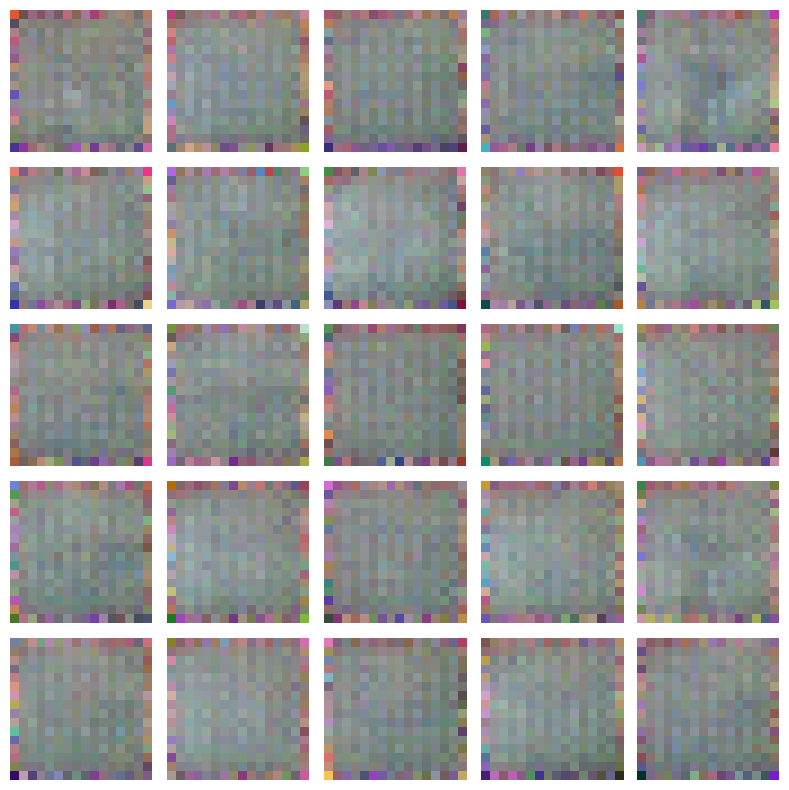

In [8]:
T = 200
image_size = 16
count_x = 5
count_y = 5

noise_scheduler = NoiseScheduler(T, device_manager)
noises = torch.randn((count_x*count_y, 3, image_size, image_size), device=device_manager.device)

images = model.generate_images(noises, T, noise_scheduler, device_manager).cpu()

fig, axes = plt.subplots(count_y, count_x, figsize=(8, 8))
axes = axes.flatten()

for ax, image in zip(axes, images):
    pil_image = model.reverse_transform(image)
    ax.imshow(pil_image)
    ax.axis('off')

plt.tight_layout()
plt.show()